In [2]:
import mne
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mat = scipy.io.loadmat("GIST_MI/s02.mat")

In [4]:
for i in mat:
    print(i)
print()

fields = list(mat['eeg'][0].dtype.fields.keys())
print("fields:", fields)

__header__
__version__
__globals__
eeg

fields: ['noise', 'rest', 'srate', 'movement_left', 'movement_right', 'movement_event', 'n_movement_trials', 'imagery_left', 'imagery_right', 'n_imagery_trials', 'frame', 'imagery_event', 'comment', 'subject', 'bad_trial_indices', 'psenloc', 'senloc']


In [5]:
eeg_ch_names = [
    "Fp1", "AF7", "AF3", "F1", "F3", "F5", "F7", "FT7", "FC5", "FC3", "FC1",
    "C1", "C3", "C5", "T7", "TP7", "CP5", "CP3", "CP1", "P1", "P3", "P5", "P7",
    "P9", "PO7", "PO3", "O1", "Iz", "Oz", "POz", "Pz", "CPz", "Fpz", "Fp2",
    "AF8", "AF4", "AFz", "Fz", "F2", "F4", "F6", "F8", "FT8", "FC6", "FC4",
    "FC2", "FCz", "Cz", "C2", "C4", "C6", "T8", "TP8", "CP6", "CP4", "CP2",
    "P2", "P4", "P6", "P8", "P10", "PO8", "PO4", "O2",
]
emg_ch_names = ["EMG1", "EMG2", "EMG3", "EMG4"]
ch_names = eeg_ch_names + emg_ch_names + ["Stim"]
ch_types = ["eeg"] * 64 + ["emg"] * 4 + ["stim"]

In [6]:
srate = mat['eeg'][0]['srate'][0][0] #eeg구조체에서 sample rate추출

# info 생성
info = mne.create_info(ch_names=ch_names, sfreq=srate, ch_types=ch_types)

# Stim channel 붙이기
left = np.vstack((mat['eeg'][0]['imagery_left'][0], mat['eeg'][0]['imagery_event'][0]))
right = np.vstack((mat['eeg'][0]['imagery_right'][0], mat['eeg'][0]['imagery_event'][0]))

In [7]:
# Raw 생성
lr = mne.io.RawArray(left, info=info)
rr = mne.io.RawArray(right, info=info)
raw = [lr, rr]

Creating RawArray with float64 data, n_channels=69, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.
Creating RawArray with float64 data, n_channels=69, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.


In [8]:
LEFT = 0
RIGHT = 1

In [9]:
mne.set_eeg_reference(raw[LEFT], ch_type='eeg')
mne.set_eeg_reference(raw[RIGHT], ch_type='eeg')

Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.


(<RawArray | 69 x 358400 (700.0 s), ~188.7 MB, data loaded>,
 array([-198106.94897461, -198080.34350586, -198162.98022461, ...,
        -209391.13250732, -209325.77313232, -209463.07391357]))

In [10]:
print("Raw의 길이:", len(raw[LEFT]))
print("초로 환산하면:", len(raw[LEFT]) / srate)
print("n_imagery_trials로 나누면:", len(raw[LEFT]) / srate / mat['eeg'][0]['n_imagery_trials'][0][0])

Raw의 길이: 358400
초로 환산하면: [700.]
n_imagery_trials로 나누면: [7.]


In [11]:
# events 생성
le = mne.find_events(raw[LEFT], stim_channel='Stim')
re = mne.find_events(raw[RIGHT], stim_channel='Stim')
events = [le, re]

100 events found on stim channel Stim
Event IDs: [1]
100 events found on stim channel Stim
Event IDs: [1]


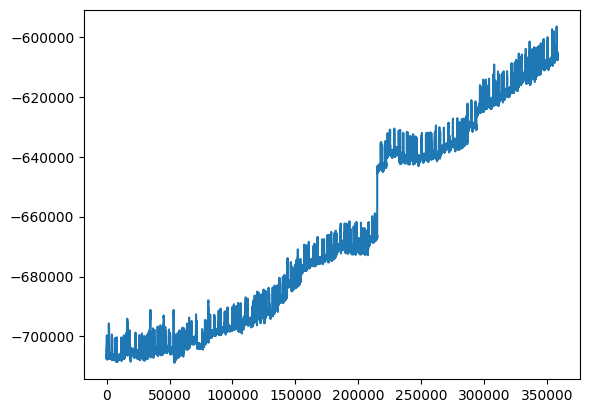

In [12]:
raw_data = raw[LEFT].get_data()
plt.plot(raw_data[0])
plt.show()

In [14]:
le = mne.Epochs(raw[LEFT], events[LEFT], tmin=-1.999, tmax=5, baseline=(-0.5, 0))
re = mne.Epochs(raw[RIGHT], events[RIGHT], tmin=-1.999, tmax=5, baseline=(-0.5, 0))
epochs = [le, re]

Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [15]:
epochs[LEFT].load_data()
epochs[RIGHT].load_data()

epochs[LEFT].pick(picks=['C3', 'C4'])
epochs[RIGHT].pick(picks=['C3', 'C4'])

Using data from preloaded Raw for 100 events and 3584 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 100 events and 3584 original time points ...
0 bad epochs dropped


Number of events,100
Events,1: 100
Time range,-1.998 – 5.000 s
Baseline,-0.500 – 0.000 s


In [16]:
C3 = 0
C4 = 1

In [17]:
print(epochs[LEFT].get_data().shape)

(100, 2, 3584)


/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/2849883524.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(epochs[LEFT].get_data().shape)


/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/3310520538.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = [epochs[LEFT].get_data(), epochs[RIGHT].get_data()]
/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/3310520538.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = [epochs[LEFT].get_data(), epochs[RIGHT].get_data()]


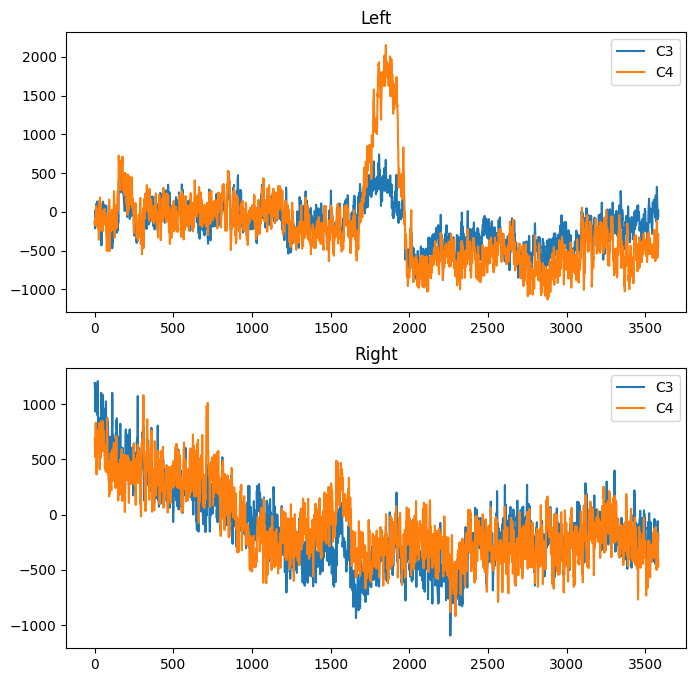

In [18]:
data = [epochs[LEFT].get_data(), epochs[RIGHT].get_data()]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

axes[0].plot(data[LEFT][0][C3], label='C3')
axes[0].plot(data[LEFT][0][C4], label='C4')
axes[0].set_title("Left")
axes[0].legend()

axes[1].plot(data[RIGHT][0][C3], label='C3')
axes[1].plot(data[RIGHT][0][C4], label='C4')
axes[1].set_title("Right")
axes[1].legend()

plt.show()

In [19]:
le = []
re = []
for i in range(0, len(epochs[LEFT])):
    le.append(epochs[LEFT][i].filter(l_freq=8, h_freq=13))
    re.append(epochs[RIGHT][i].filter(l_freq=8, h_freq=13))
epochs = [le, re]

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 845 samples (1.650 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/649023672.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = [epochs[LEFT][0].get_data(), epochs[RIGHT][0].get_data()]
/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/649023672.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = [epochs[LEFT][0].get_data(), epochs[RIGHT][0].get_data()]


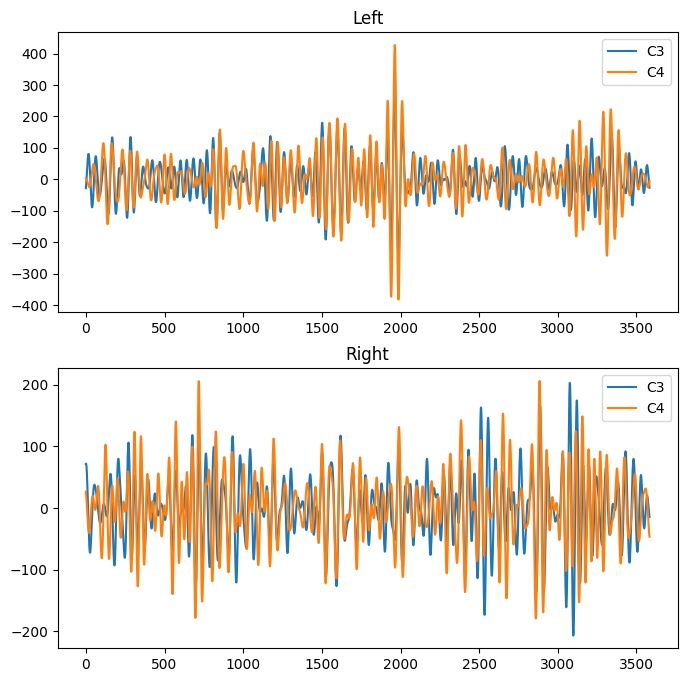

In [20]:
data = [epochs[LEFT][0].get_data(), epochs[RIGHT][0].get_data()]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

axes[0].plot(data[LEFT][0][C3], label='C3')
axes[0].plot(data[LEFT][0][C4], label='C4')
axes[0].set_title("Left")
axes[0].legend()

axes[1].plot(data[RIGHT][0][C3], label='C3')
axes[1].plot(data[RIGHT][0][C4], label='C4')
axes[1].set_title("Right")
axes[1].legend()

plt.show()

/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/902616886.py:9: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = [epochs[LEFT][0].get_data(), epochs[RIGHT][0].get_data()]
/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/902616886.py:9: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = [epochs[LEFT][0].get_data(), epochs[RIGHT][0].get_data()]


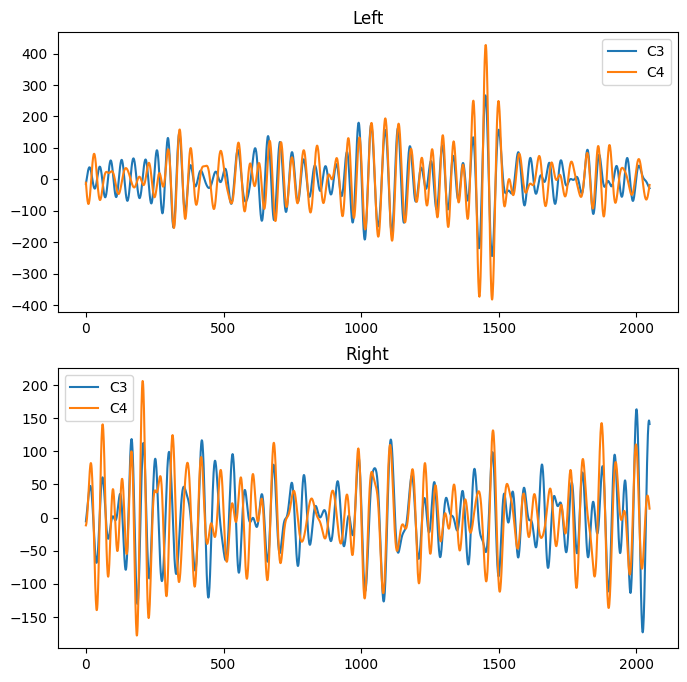

In [21]:
le = []
re = []
for i in range(0, len(epochs[LEFT])):
    le.append(epochs[LEFT][i].crop(tmin=-1, tmax=3))
    re.append(epochs[RIGHT][i].crop(tmin=-1, tmax=3))
epochs = [le, re]

# 예시 데이터 plot
data = [epochs[LEFT][0].get_data(), epochs[RIGHT][0].get_data()]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

axes[0].plot(data[LEFT][0][C3], label='C3')
axes[0].plot(data[LEFT][0][C4], label='C4')
axes[0].set_title("Left")
axes[0].legend()

axes[1].plot(data[RIGHT][0][C3], label='C3')
axes[1].plot(data[RIGHT][0][C4], label='C4')
axes[1].set_title("Right")
axes[1].legend()

plt.show()

In [22]:
ld = []
rd = []
for i in range(0, len(epochs[LEFT])):
    ld.append(epochs[LEFT][i].get_data()[0])
    rd.append(epochs[RIGHT][i].get_data()[0])
data = [ld, rd]

/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/1122644876.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ld.append(epochs[LEFT][i].get_data()[0])
/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/1122644876.py:5: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  rd.append(epochs[RIGHT][i].get_data()[0])
/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/1122644876.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ld.append(epochs[LEFT][i].get_data()[0])
/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/1122644876.py:5: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warnin

In [23]:
data = [np.abs(data[LEFT]), np.abs(data[RIGHT])]

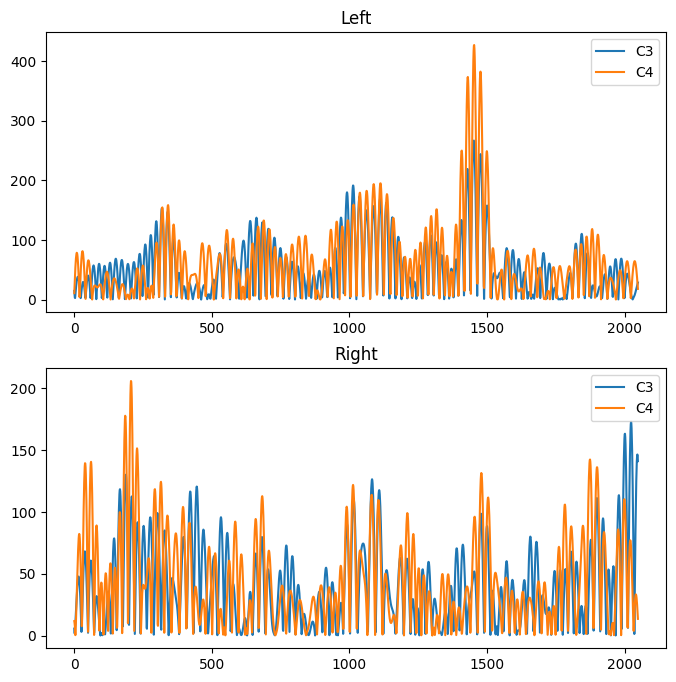

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

axes[0].plot(data[LEFT][0][C3], label='C3')
axes[0].plot(data[LEFT][0][C4], label='C4')
axes[0].set_title("Left")
axes[0].legend()

axes[1].plot(data[RIGHT][0][C3], label='C3')
axes[1].plot(data[RIGHT][0][C4], label='C4')
axes[1].set_title("Right")
axes[1].legend()

plt.show()

In [25]:
data = [np.mean(data[LEFT], axis=0), np.mean(data[RIGHT], axis=0)]

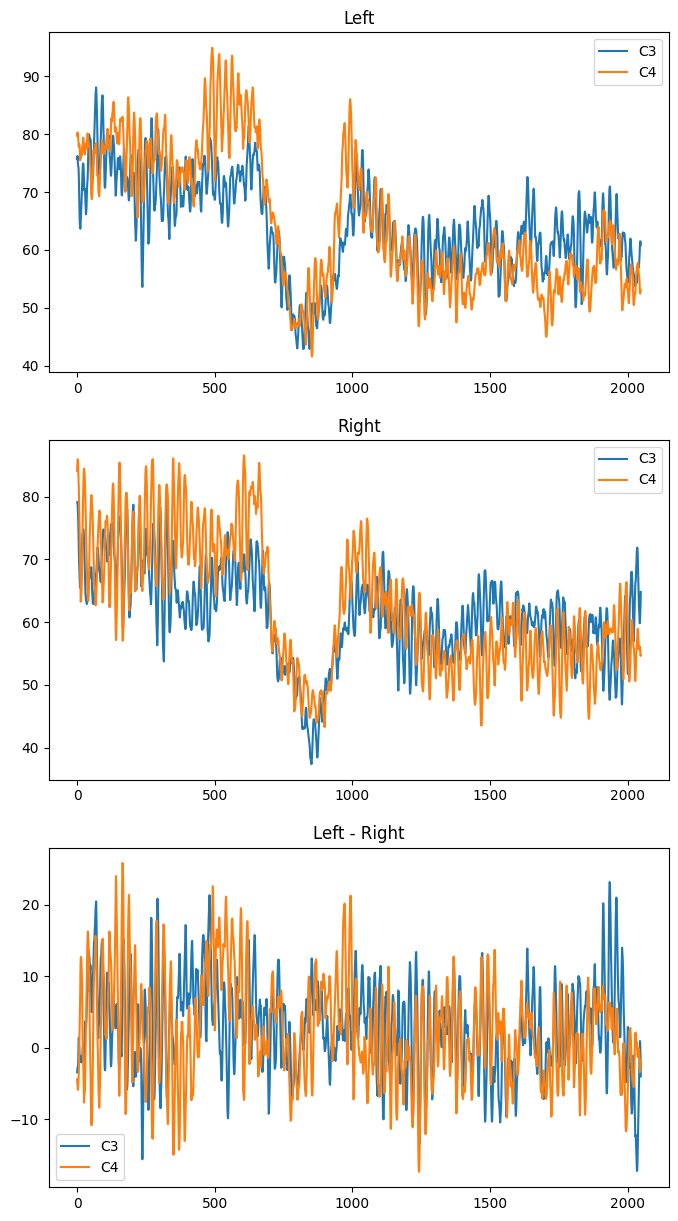

In [26]:
# 예시 데이터 plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 15))

axes[0].plot(data[LEFT][C3], label='C3')
axes[0].plot(data[LEFT][C4], label='C4')
axes[0].set_title("Left")
axes[0].legend()

axes[1].plot(data[RIGHT][C3], label='C3')
axes[1].plot(data[RIGHT][C4], label='C4')
axes[1].set_title("Right")
axes[1].legend()

axes[2].plot(data[LEFT][C3] - data[RIGHT][C3], label='C3')
axes[2].plot(data[LEFT][C4] - data[RIGHT][C4], label='C4')
axes[2].set_title("Left - Right")
axes[2].legend()

plt.show()

In [27]:
R = [np.mean(data[LEFT][:, :513], axis=1).reshape(2,1), np.mean(data[RIGHT][:, :513], axis=1).reshape(2,1)]
ERD = [(data[LEFT] - R[LEFT]) / R[LEFT] * 100, (data[RIGHT] - R[RIGHT]) / R[RIGHT] * 100]

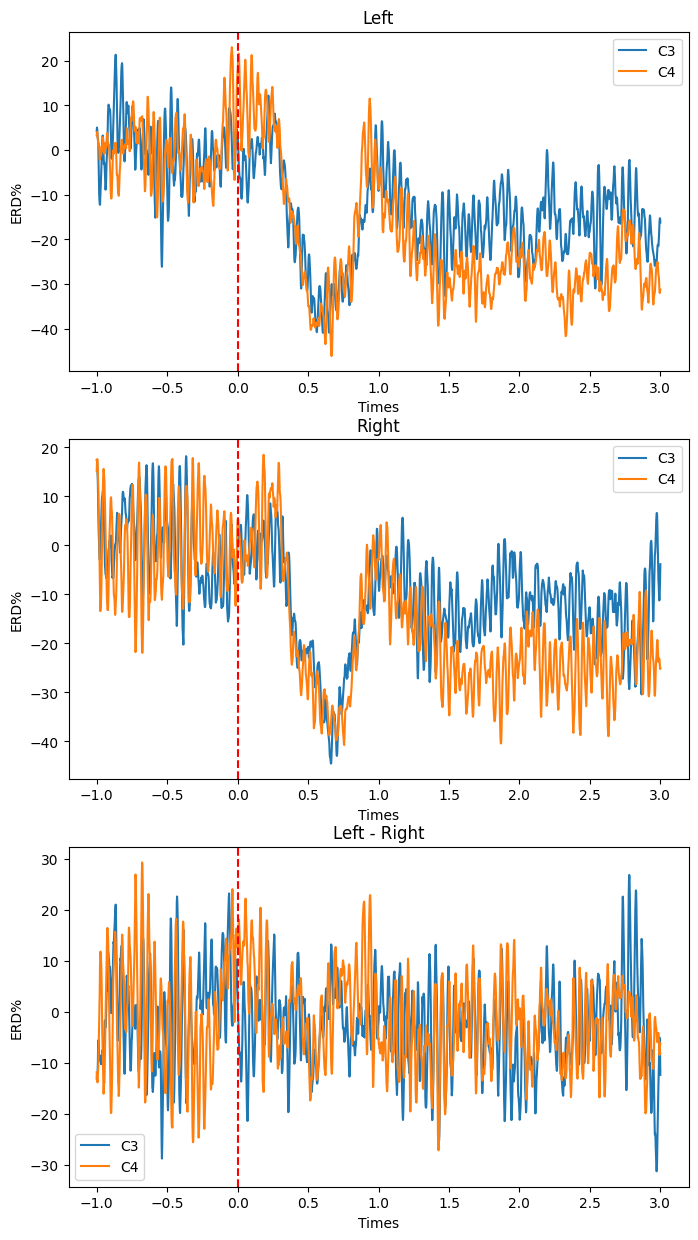

In [28]:
# 예시 데이터 plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 15))

axes[0].plot((np.arange(len(ERD[LEFT][C3])) - 512) / 512, ERD[LEFT][C3], label='C3')
axes[0].plot((np.arange(len(ERD[LEFT][C4])) - 512) / 512, ERD[LEFT][C4], label='C4')
axes[0].set_title("Left")
axes[0].set_xlabel("Times")
axes[0].set_ylabel("ERD%")
axes[0].legend()

axes[1].plot((np.arange(len(ERD[RIGHT][C3])) - 512) / 512, ERD[RIGHT][C3], label='C3')
axes[1].plot((np.arange(len(ERD[RIGHT][C4])) - 512) / 512, ERD[RIGHT][C4], label='C4')
axes[1].set_title("Right")
axes[1].set_xlabel("Times")
axes[1].set_ylabel("ERD%")
axes[1].legend()

axes[2].plot((np.arange(len(ERD[RIGHT][C3])) - 512) / 512, ERD[LEFT][C3] - ERD[RIGHT][C3], label='C3')
axes[2].plot((np.arange(len(ERD[RIGHT][C3])) - 512) / 512, ERD[LEFT][C4] - ERD[RIGHT][C4], label='C4')
axes[2].set_title("Left - Right")
axes[2].set_xlabel("Times")
axes[2].set_ylabel("ERD%")
axes[2].legend()

for ax in axes:
    ax.axvline(x=0, color='red', linestyle='--')

plt.show()

In [29]:
for i in range(0, len(epochs[LEFT])):
    epochs[LEFT][i].apply_hilbert()
    epochs[RIGHT][i].apply_hilbert()

ld = []
rd = []
for i in range(0, len(epochs[LEFT])):
    ld.append(epochs[LEFT][i].get_data()[0])
    rd.append(epochs[RIGHT][i].get_data()[0])
data = [ld, rd]

/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/3675287462.py:8: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ld.append(epochs[LEFT][i].get_data()[0])
/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/3675287462.py:9: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  rd.append(epochs[RIGHT][i].get_data()[0])
/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/3675287462.py:8: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ld.append(epochs[LEFT][i].get_data()[0])
/var/folders/g5/xx3rg60d1hg5vf4tb1npq5g80000gn/T/ipykernel_5298/3675287462.py:9: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warnin

In [30]:
data = [np.abs(data[LEFT]), np.abs(data[RIGHT])]

data = [np.mean(data[LEFT], axis=0), np.mean(data[RIGHT], axis=0)]

R = [np.mean(data[LEFT][:, 0:513], axis=1).reshape(2,1), np.mean(data[RIGHT][:, 0:513], axis=1).reshape(2,1)]
ERD = [(data[LEFT] - R[LEFT]) / R[LEFT] * 100, (data[RIGHT] - R[RIGHT]) / R[RIGHT] * 100]

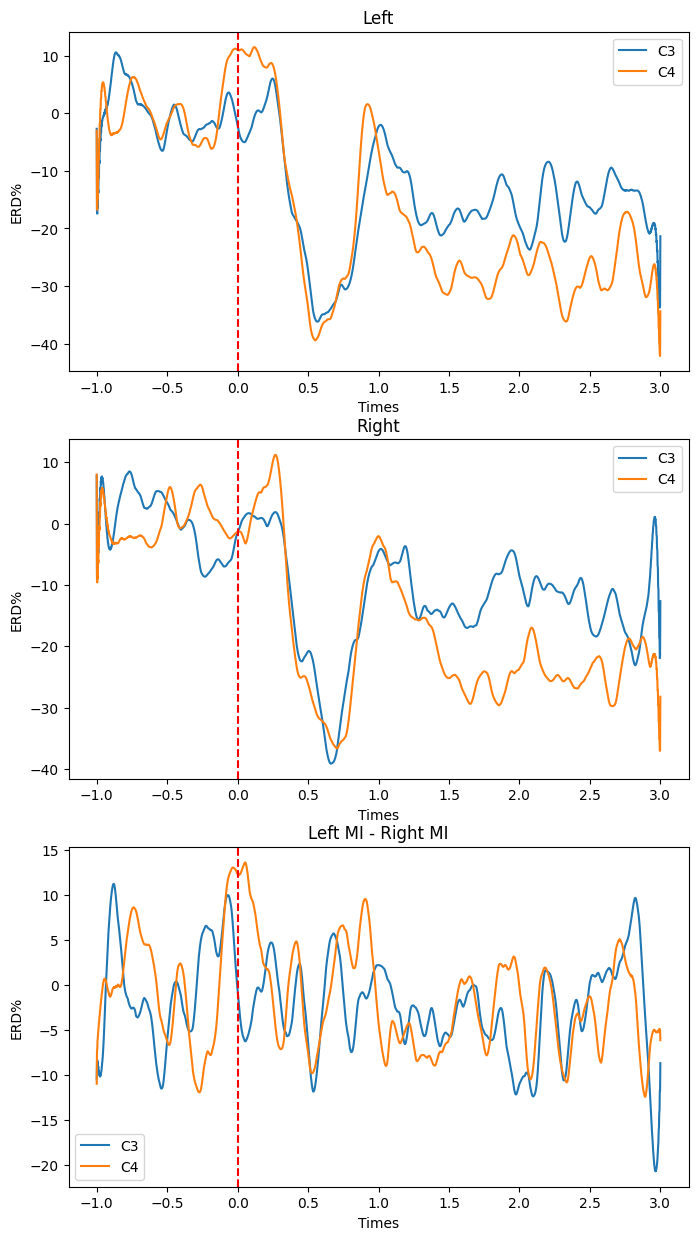

In [31]:
# 예시 데이터 plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 15))

axes[0].plot((np.arange(len(ERD[LEFT][C3])) - 512) / 512, ERD[LEFT][C3], label='C3')
axes[0].plot((np.arange(len(ERD[LEFT][C4])) - 512) / 512, ERD[LEFT][C4], label='C4')
axes[0].set_title("Left")
axes[0].set_xlabel("Times")
axes[0].set_ylabel("ERD%")
axes[0].legend()

axes[1].plot((np.arange(len(ERD[RIGHT][C3])) - 512) / 512, ERD[RIGHT][C3], label='C3')
axes[1].plot((np.arange(len(ERD[RIGHT][C4])) - 512) / 512, ERD[RIGHT][C4], label='C4')
axes[1].set_title("Right")
axes[1].set_xlabel("Times")
axes[1].set_ylabel("ERD%")
axes[1].legend()

axes[2].plot((np.arange(len(ERD[RIGHT][C3])) - 512) / 512, ERD[LEFT][C3] - ERD[RIGHT][C3], label='C3')
axes[2].plot((np.arange(len(ERD[RIGHT][C3])) - 512) / 512, ERD[LEFT][C4] - ERD[RIGHT][C4], label='C4')
axes[2].set_title("Left MI - Right MI")
axes[2].set_xlabel("Times")
axes[2].set_ylabel("ERD%")
axes[2].legend()

for ax in axes:
    ax.axvline(x=0, color='red', linestyle='--')

plt.show()